In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [3]:
feedline_resonator_gap = 13 
n_gridline = 20
JJtype = "mh" # mh or dl (manhattan or dolan)
Bandage = False
DCLine = True # Add DC line next to squids
Entangle = True # Connect two transmons
SimulationDesign = False # Make inverted design for HFSS simulation (This takes a long time...)

outname = "TcSampleDesign"

config = load_config( f"config/common_Tc.yaml" )
# グローバル変数として定義
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


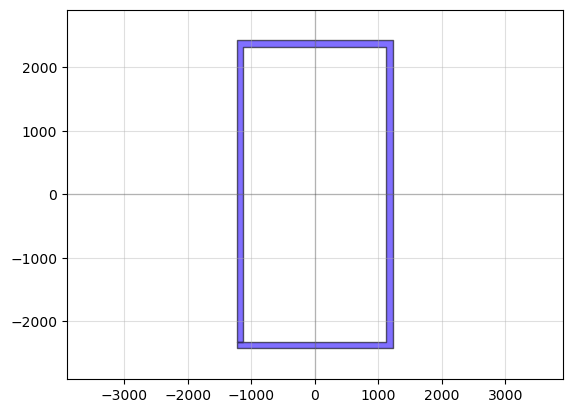

In [5]:
chipdesign = Device('chipdesign')

FM=Device('frame')
rectangle = pg.rectangle((Frame_size_width, Frame_size_height), Frame_layer)
FM.add_ref( pg.invert(rectangle, border = Frame_width, precision = 1e-6, layer = Frame_layer) )
FM.center = (0, 0)

chipdesign.add_ref(FM)
# Quickplot the imported design
qp(chipdesign)

# Launch pad

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


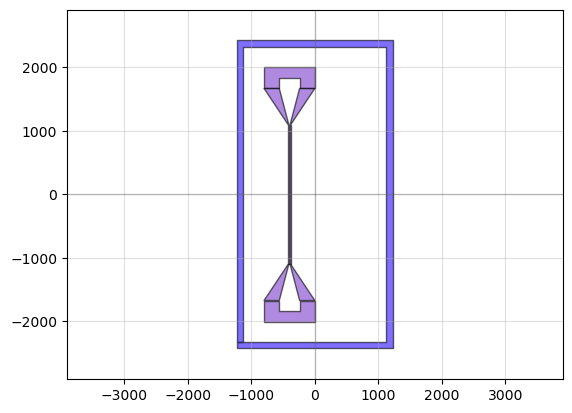

In [6]:
FL = device_FeedLine_Tc()
FL.movex(-400)
chipdesign.add_ref(FL)
qp(chipdesign)


# Corner points

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


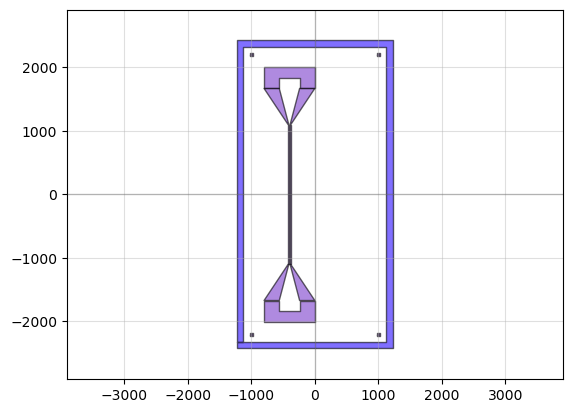

In [7]:
CP = device_CornerPoints()
chipdesign.add_ref(CP)
qp(chipdesign)

# Resonator

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Length : 3235.284135321223 [um]
Length : 3635.2841353212234 [um]
eps_eff :  6.450414364739247
9.121252462448197
eps_eff :  6.450414364739247
8.117616749484348
eps_eff :  6.450414364739247
9.07995181108255


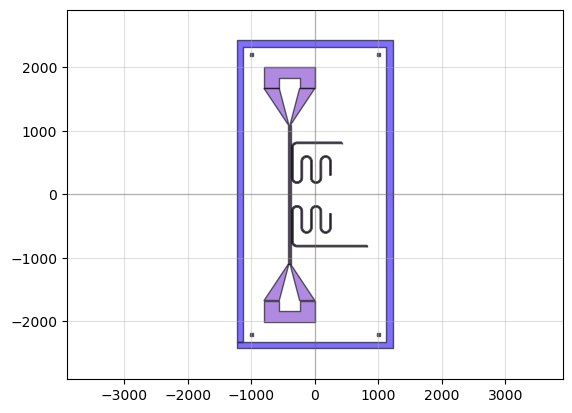

In [8]:
R1_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 700, transmon = False, mirror = True, print_length = True)
R1_tmp.rotate(-90)
R1_tmp.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap
R1_tmp.y = 500
R1 = pg.copy_layer(R1_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R1)

R2_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1100, transmon = False, print_length = True)
R2_tmp.rotate(90)
R2_tmp.y = -500
R2_tmp.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap
R2 = pg.copy_layer(R2_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R2)

print( calculate_resonator_frequency(length = 3235.284135321223) * 1e-9 )
print( calculate_resonator_frequency(length = 3635.2841353212234) * 1e-9 )
print( calculate_resonator_frequency(length = 3250) * 1e-9)

chipdesign.write_gds('output/test.gds')
qp(chipdesign)

## Make inverted design for simulation

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


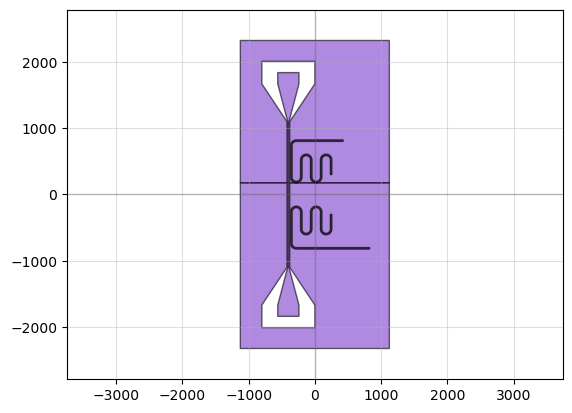

In [9]:
chipdesign_inverted = Device('chipdesign_inverted')
chipdesign_inverted.add_ref(FL)
chipdesign_inverted.add_ref(R1_tmp)
chipdesign_inverted.add_ref(R2_tmp)
rectangle = pg.rectangle((Frame_size_width, Frame_size_height), 0)
rectangle.center = (0,0)
trace = pg.copy_layer(chipdesign_inverted, 1, Resonator_layer)
chipdesign_inverted = pg.boolean(rectangle, chipdesign_inverted, operation = 'not', layer = Resonator_layer)
chipdesign_inverted.add_ref(trace)
chipdesign_inverted.write_gds('output/TcSampleDesign_simulation.gds')
qp(chipdesign_inverted)

## Make inverted design for Qiskit-metal

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


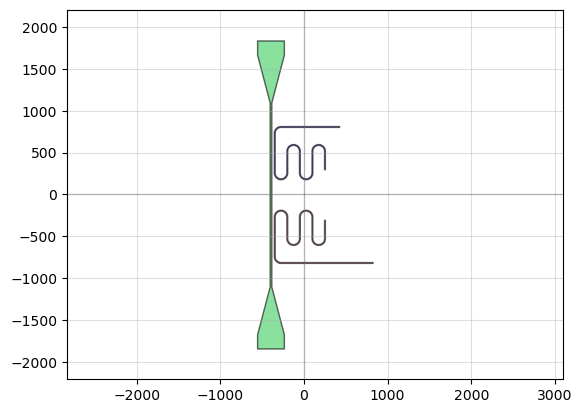

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


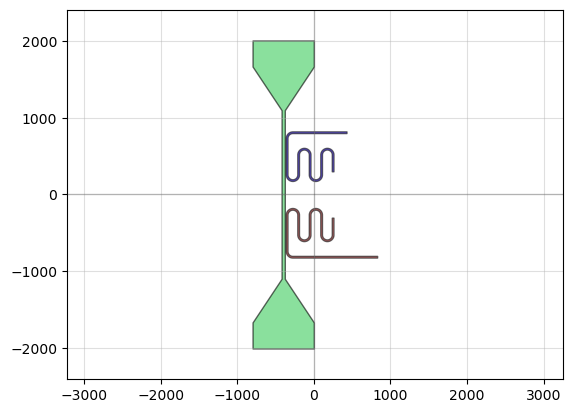

{'FeedLine': {'layer': 0, 'ports': {'LaunchPad0': {'start': [-239.99999999999994, 2010.0], 'end': [-560.0, 2010.0], 'width': 320.0, 'gap': 170.0}, 'LaunchPad1': {'start': [-560.0, -2010.0], 'end': [-239.99999999999994, -2010.0], 'width': 320.0, 'gap': 170.0}}}, 'Resonator1': {'layer': 1}, 'Resonator2': {'layer': 2}}


In [13]:
FL_qiskit_pocket = device_FeedLine_Tc(pocket = True)
FL_qiskit_pocket.movex(-400)

R1_qiskit_pocket = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 700, transmon = False, mirror = True, print_length = False, pocket = True)
R1_qiskit_pocket.rotate(-90)
R1_qiskit_pocket.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap
R1_qiskit_pocket.y = 500

R2_qiskit_pocket = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1100, transmon = False, print_length = False, pocket = True)
R2_qiskit_pocket.rotate(90)
R2_qiskit_pocket.y = -500
R2_qiskit_pocket.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap

pocket_list = [FL_qiskit_pocket, R1_qiskit_pocket, R2_qiskit_pocket]
metal_list = [FL, R1, R2]
name_list = ["FeedLine", "Resonator1", "Resonator2"]


phidl_to_metal(
    pocket_list = pocket_list, 
    metal_list = metal_list, 
    name_list = name_list, 
    outname = outname,
    LaunchPad_gap = LaunchPad_pad_gap_length - LaunchPad_pad_length,
)

In [ ]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign) 

    return chip

# Place chip designs

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


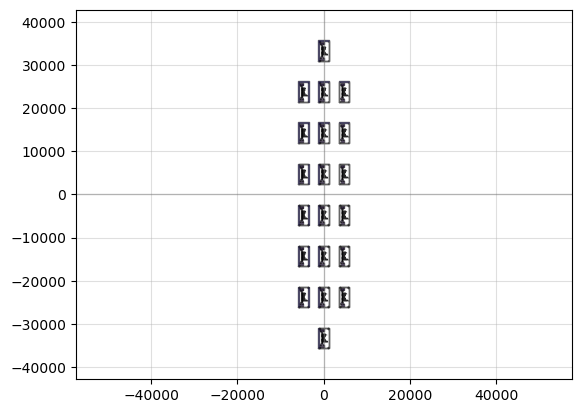

In [ ]:


D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  Grid_width},
    param_y = {'height' : Grid_height},
    spacing = (Grid_gap_x * Frame_size_width, Grid_gap_y * Frame_size_height),
    label_layer = None
    )
D.center = (0,0)

## Remove corners
for iref, ref in enumerate(D.references[:]):
    if iref == 0 or iref == len(Grid_width)-1 or iref == len(Grid_width) * (len(Grid_height)-1) or iref == len(Grid_width) * len(Grid_height) - 1:
        D.remove(ref)

wafer.add_ref(D)
qp(D)


# Add grid lines

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


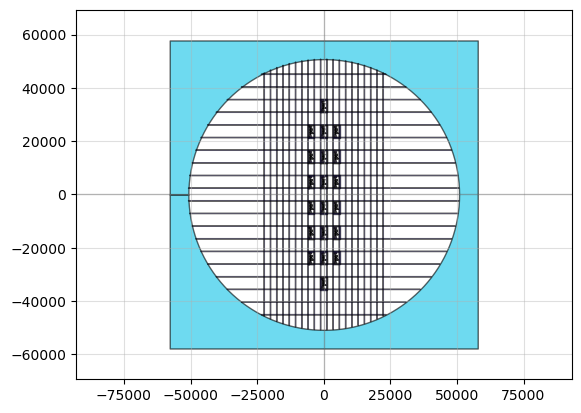

In [ ]:
grid = device_Grid(inch = 4, n_gridline = n_gridline)
wafer.add_ref( grid )

qp(wafer)


In [ ]:
wafer.write_gds('output/' + outname)

'output/TcSampleDesign.gds'